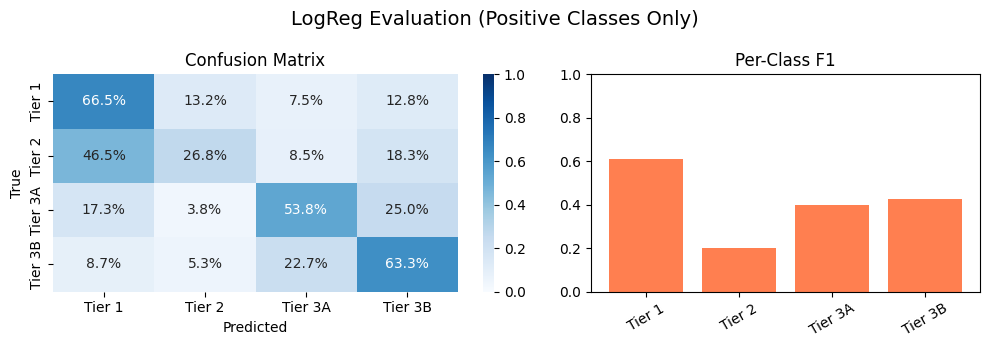

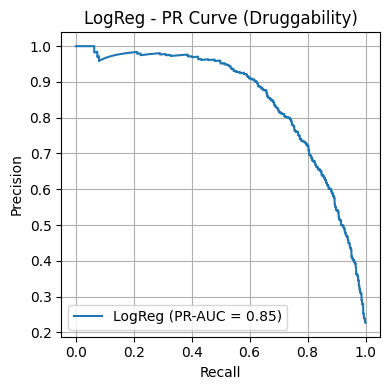

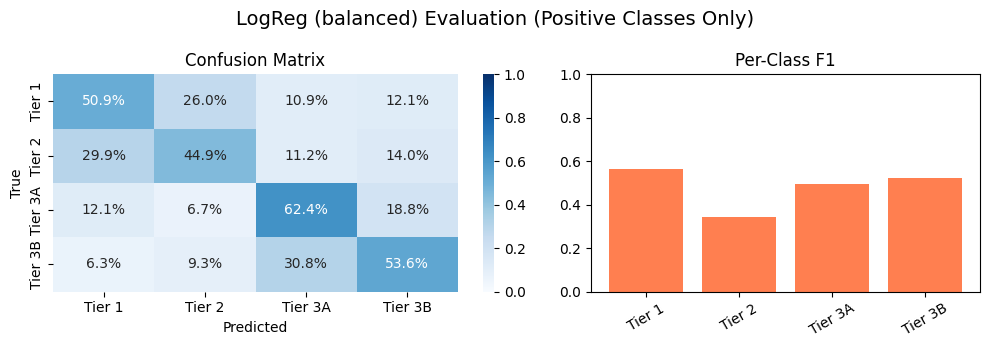

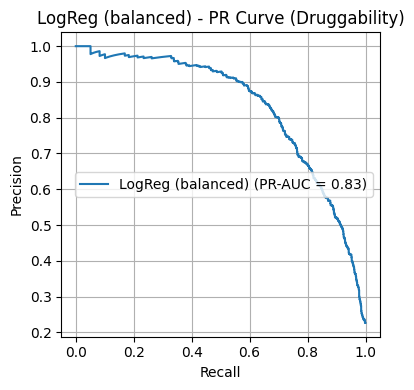

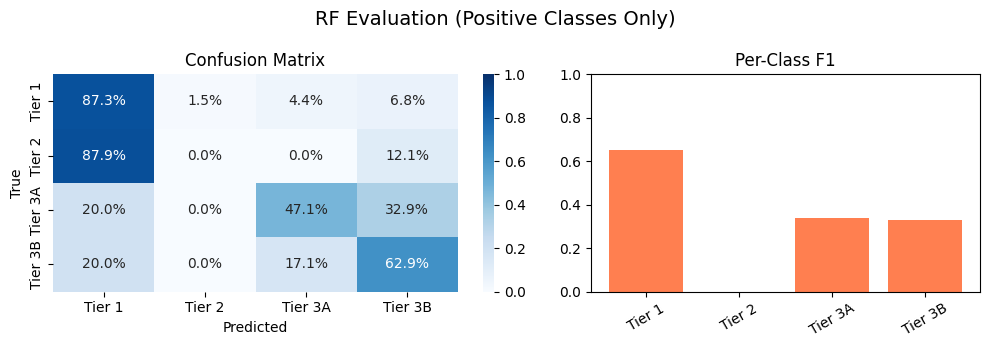

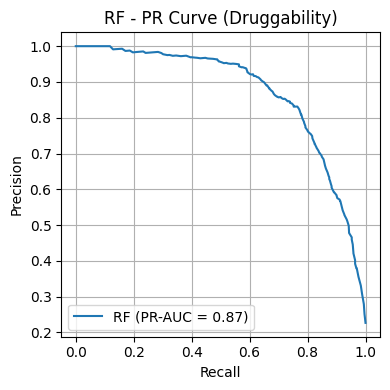

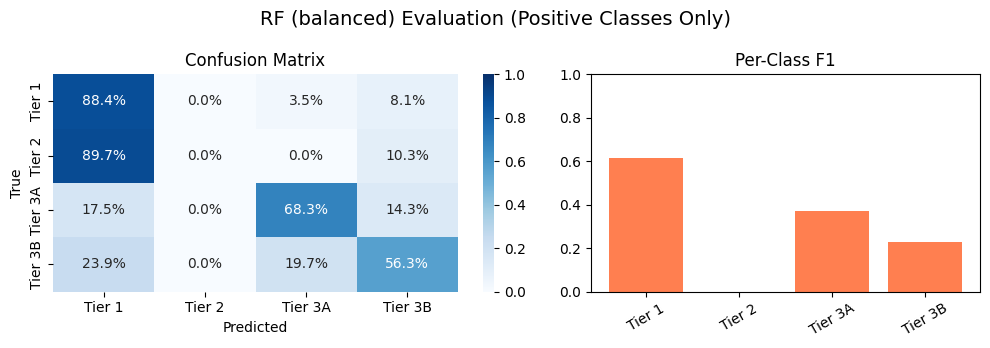

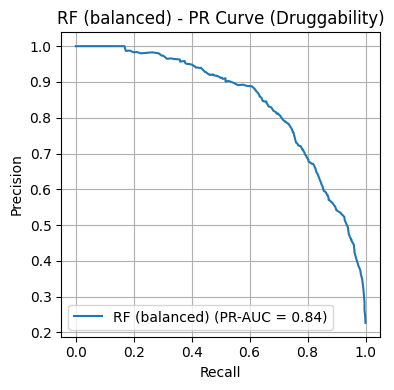

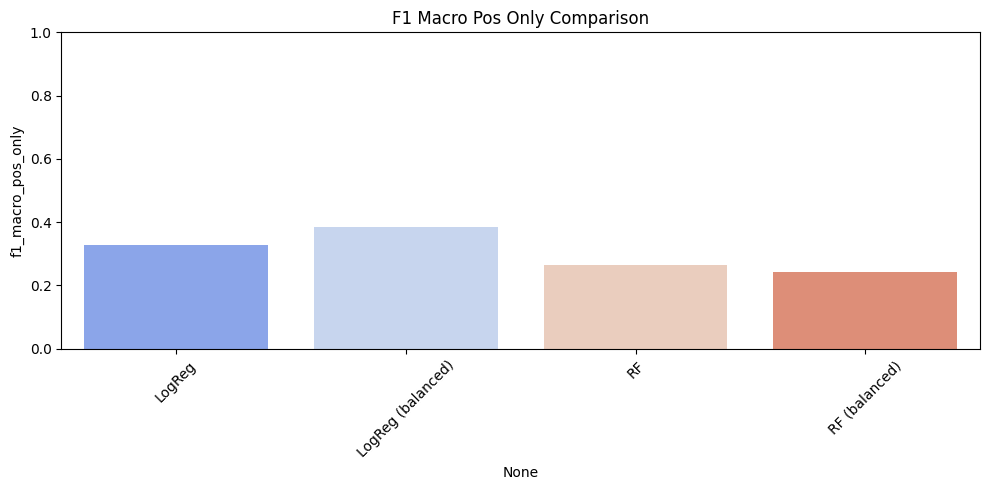

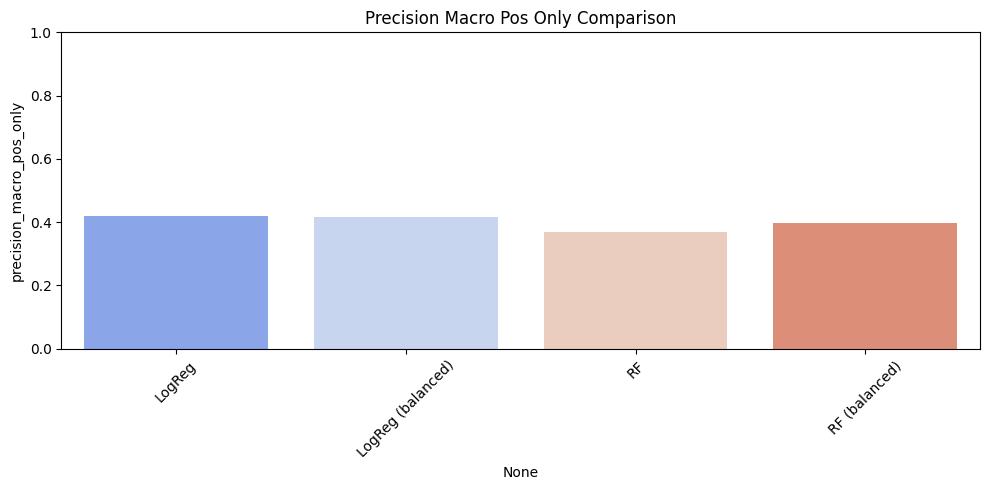

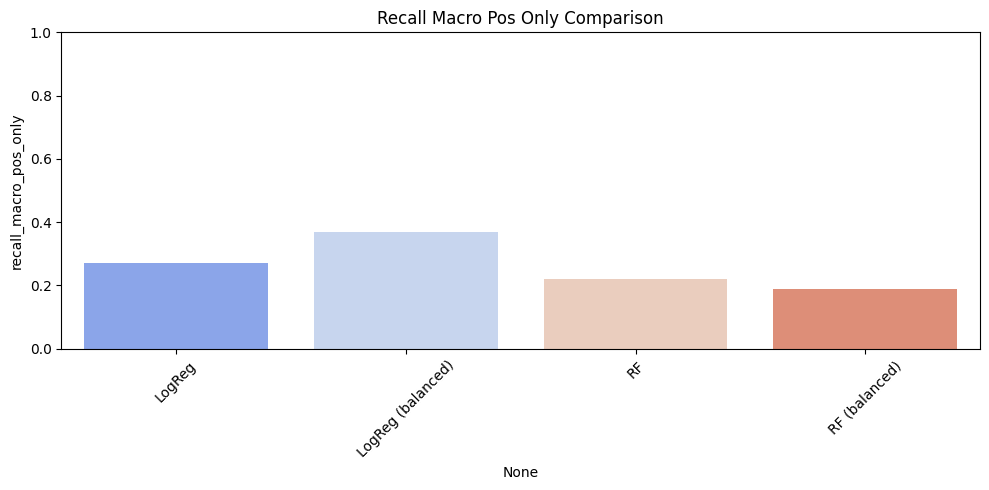

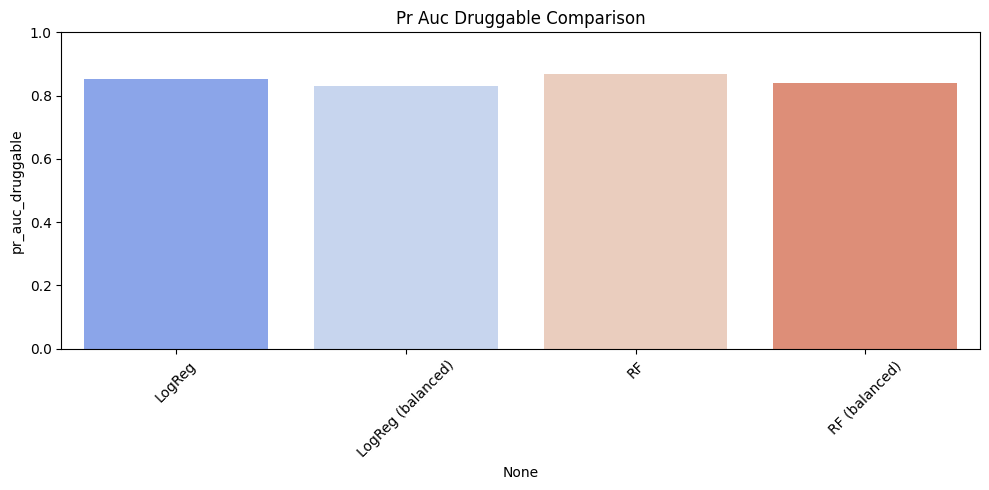


Summary Metrics:
                  f1_macro_pos_only precision_macro_pos_only  \
LogReg                     0.326348                  0.41844   
LogReg (balanced)          0.384829                 0.415027   
RF                         0.264742                 0.367768   
RF (balanced)              0.243301                 0.397578   

                  recall_macro_pos_only pr_auc_druggable  
LogReg                         0.270421         0.851651  
LogReg (balanced)              0.370112         0.829758  
RF                             0.221792         0.868959  
RF (balanced)                  0.188546          0.84091  


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ----------------------------- SETUP -----------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------------- Load data from graph ---------------------
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
data = torch.load(GRAPH_PATH)
if torch.isnan(data.x).any():
    data.x[torch.isnan(data.x)] = 0
X_all = data.x.cpu().numpy()

# ------------------------ Label processing ------------------------
y_raw = np.array(data.y)
label_map = {'-1': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 3A': 3, 'Tier 3B': 4}
y = np.vectorize(label_map.get)(y_raw)
class_names = ["Non-druggable", "Tier 1", "Tier 2", "Tier 3A", "Tier 3B"]
y_bin = label_binarize(y, classes=np.arange(len(class_names)))

# ----------------------- Train-test split -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=SEED
)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------ Model dictionary ------------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=SEED),
    "LogReg (balanced)": LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', random_state=SEED),
    "RF": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "RF (balanced)": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED),
    # "SVM (linear)": SVC(kernel='linear', probability=True, random_state=SEED),
    # "Naive Bayes": GaussianNB(),
    # "KNN": KNeighborsClassifier(n_neighbors=5),
    # "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    # "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=SEED),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=SEED)
}

# -------------------- Modified Evaluation with PR Curve ---------------------
from sklearn.metrics import precision_recall_curve

def is_druggable_class(y):  # Tier 1–3B = 1, Non-druggable = 0
    return np.where(y > 0, 1, 0)

results = {}
for name, clf in models.items():
    use_scaled = any(k in name for k in ["LogReg", "SVM", "Naive", "KNN", "MLP"])
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te) if hasattr(clf, "predict_proba") else None

    # Task 1: Binary PR-AUC — 是否 Druggable
    y_test_druggable = is_druggable_class(y_test)
    if y_prob is not None:
        druggable_score = y_prob[:, 1:].sum(axis=1)  # sum Tier1–3B probability
        pr_auc = average_precision_score(y_test_druggable, druggable_score)
    else:
        pr_auc = np.nan

    # Task 2: 多分类评估，仅在 known positives（Tier 1–3B）
    known_pos_idx = y_test != 0
    if np.sum(known_pos_idx) > 0:
        y_true_pos = y_test[known_pos_idx]
        y_pred_pos = y_pred[known_pos_idx]
        f1 = f1_score(y_true_pos, y_pred_pos, average="macro")
        prec = precision_score(y_true_pos, y_pred_pos, average="macro")
        rec = recall_score(y_true_pos, y_pred_pos, average="macro")
        cm = confusion_matrix(y_true_pos, y_pred_pos, labels=[1, 2, 3, 4])
        cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        report = classification_report(
            y_true_pos, y_pred_pos, labels=[1, 2, 3, 4],
            output_dict=True, target_names=class_names[1:]
        )
    else:
        f1 = prec = rec = np.nan
        cm = cm_norm = report = None

    results[name] = {
        "f1_macro_pos_only": f1,
        "precision_macro_pos_only": prec,
        "recall_macro_pos_only": rec,
        "pr_auc_druggable": pr_auc,
        "cm": cm_norm,
        "report": report
    }

    # 可视化
    if cm_norm is not None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), gridspec_kw={'width_ratios': [1.3, 1]})
        fig.suptitle(f"{name} Evaluation (Positive Classes Only)", fontsize=14)

        sns.heatmap(cm_norm, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=1,
                    xticklabels=class_names[1:], yticklabels=class_names[1:], ax=axs[0])
        axs[0].set_title("Confusion Matrix")
        axs[0].set_xlabel("Predicted")
        axs[0].set_ylabel("True")

        f1s = [report[c]["f1-score"] for c in class_names[1:] if c in report]
        axs[1].bar(class_names[1:len(f1s)+1], f1s, color="coral")
        axs[1].set_ylim(0, 1)
        axs[1].set_title("Per-Class F1")
        axs[1].tick_params(axis="x", rotation=30)
        plt.tight_layout()
        plt.show()

    # PR 曲线绘制（是否成药任务）
    if y_prob is not None:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test_druggable, druggable_score)
        plt.figure(figsize=(4, 4))
        plt.plot(recall_vals, precision_vals, label=f"{name} (PR-AUC = {pr_auc:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{name} - PR Curve (Druggability)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ---------------------- Summary Plot ----------------------
df_results = pd.DataFrame(results).T
df_results = df_results[[
    "f1_macro_pos_only", "precision_macro_pos_only", "recall_macro_pos_only", "pr_auc_druggable"
]]

for metric in df_results.columns:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=df_results.index, y=df_results[metric], palette="coolwarm")
    plt.title(f"{metric.replace('_', ' ').title()} Comparison")
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

print("\nSummary Metrics:")
print(df_results.round(3))


--- Evaluating Model: LogReg ---


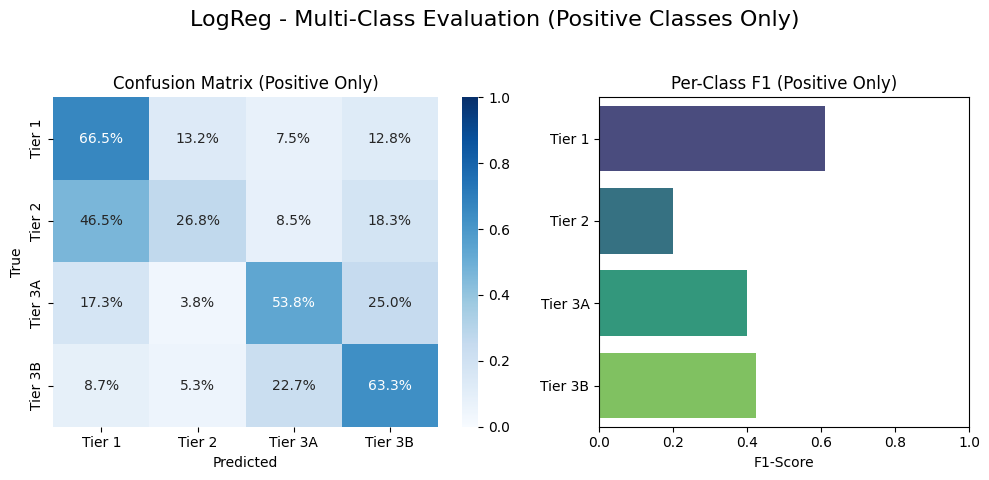

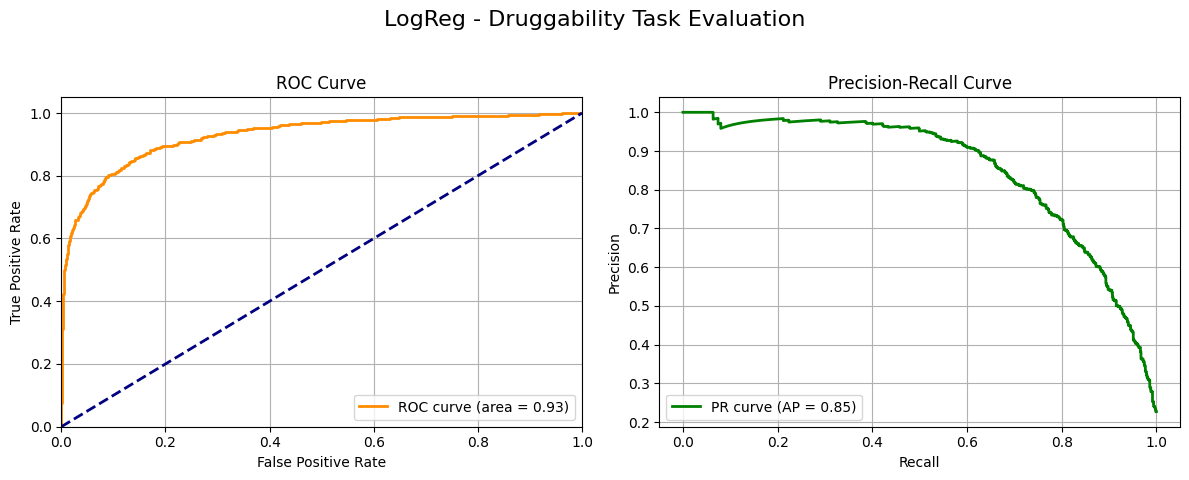


--- Evaluating Model: LogReg (balanced) ---


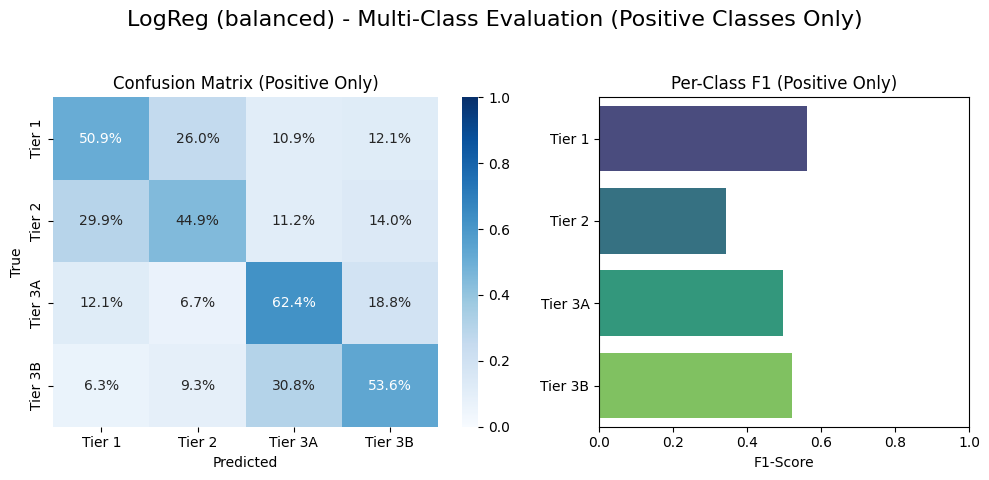

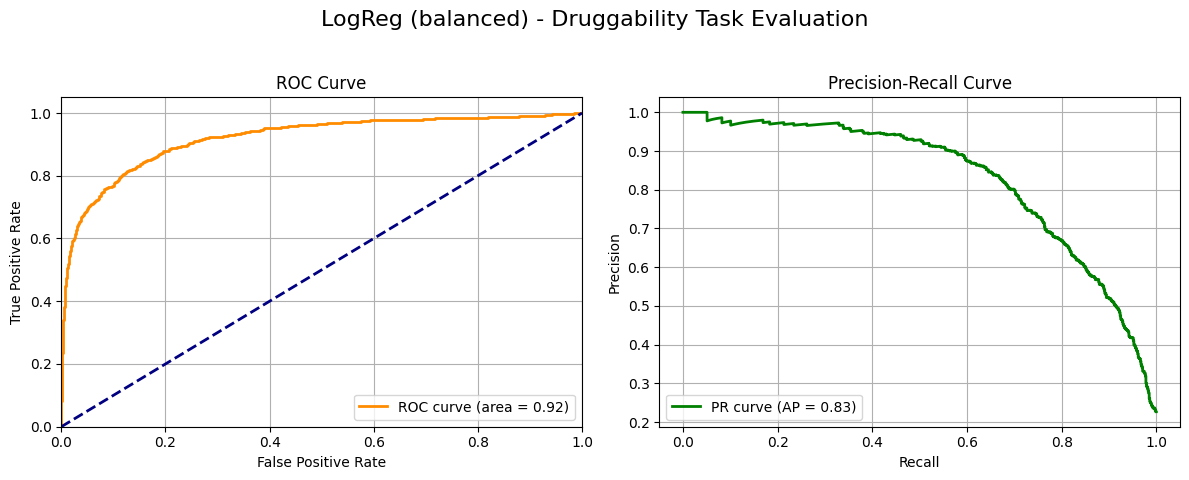


--- Evaluating Model: RF ---


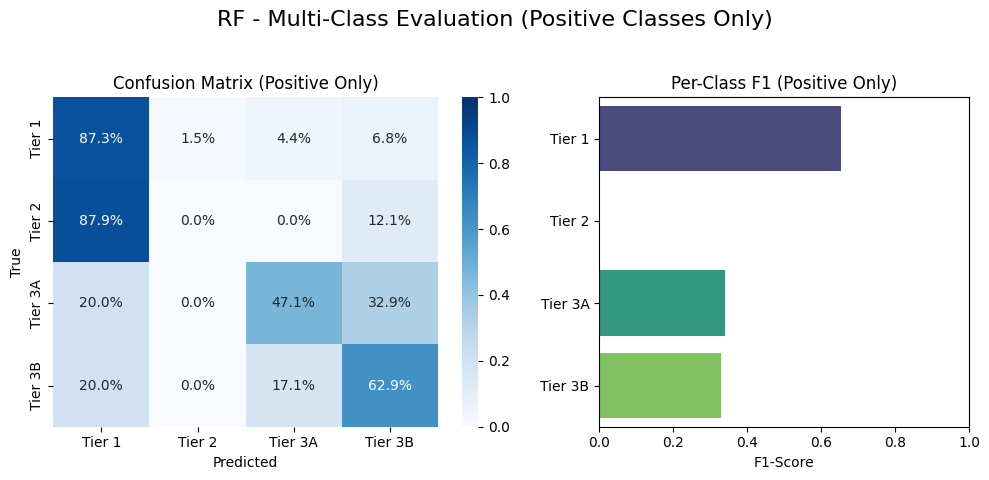

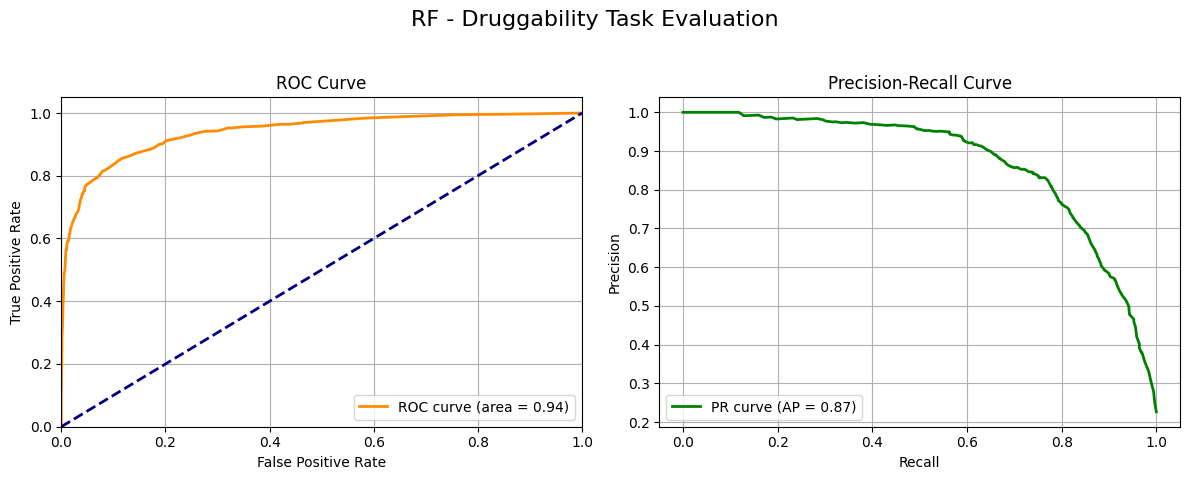


--- Evaluating Model: RF (balanced) ---


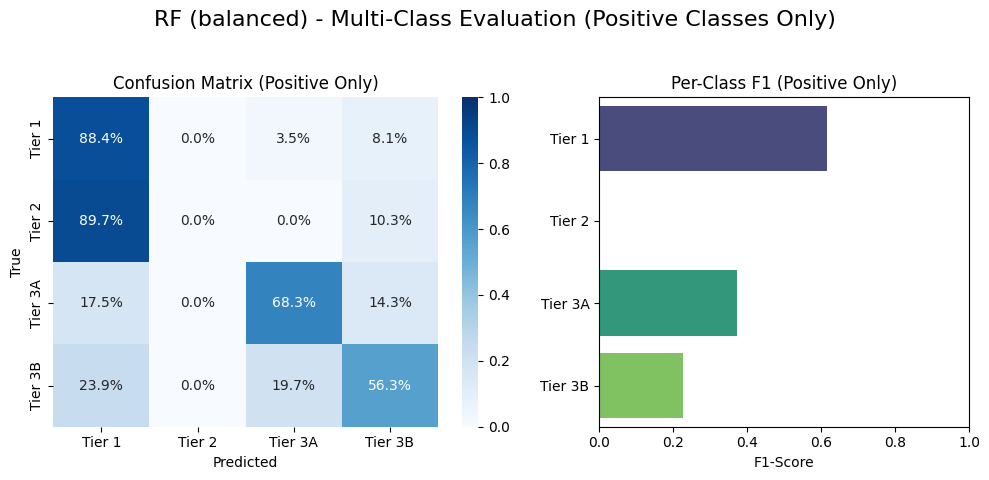

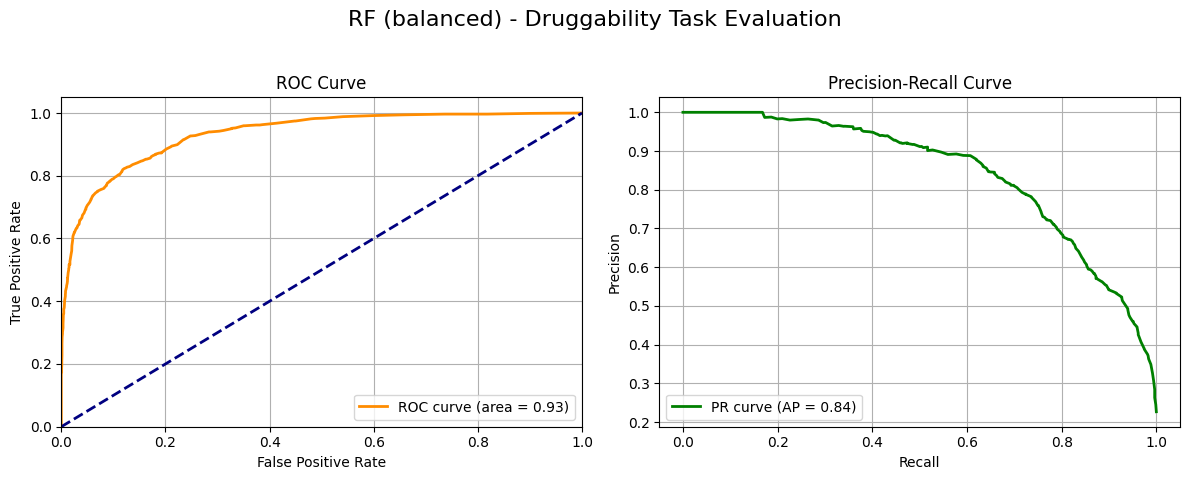


--- Evaluating Model: SVM (linear) ---


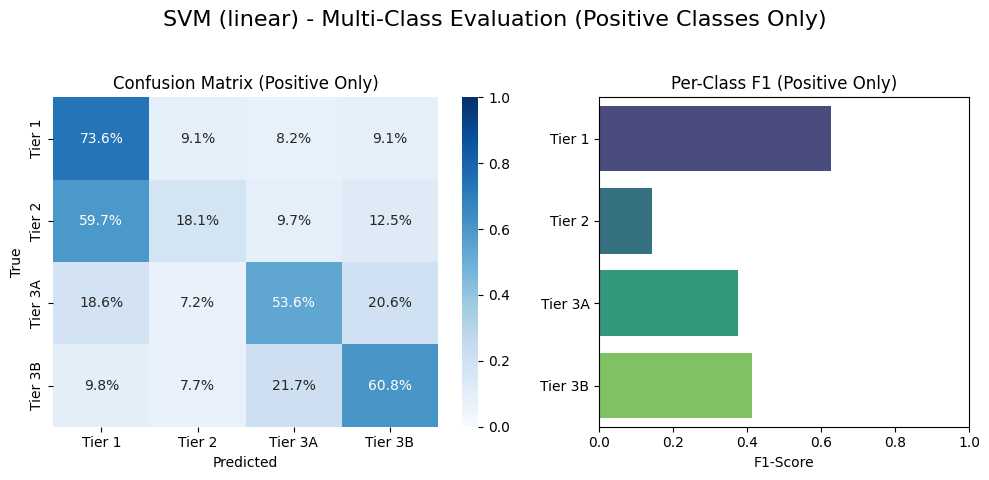

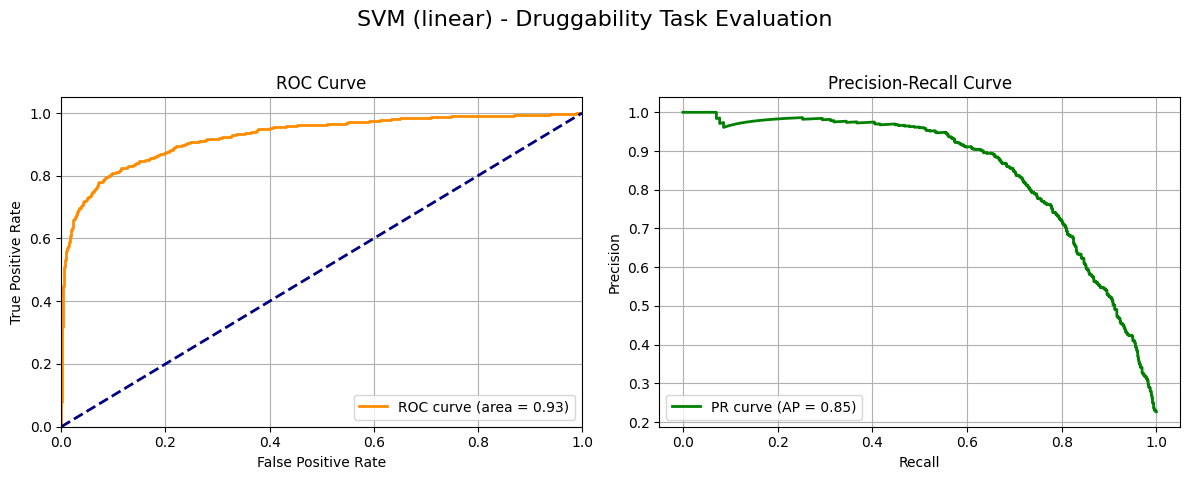


--- Evaluating Model: Naive Bayes ---


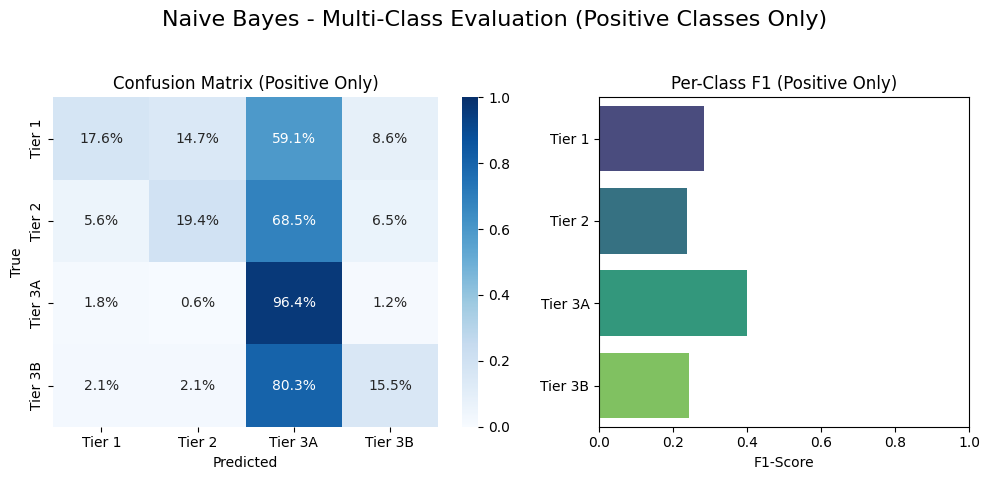

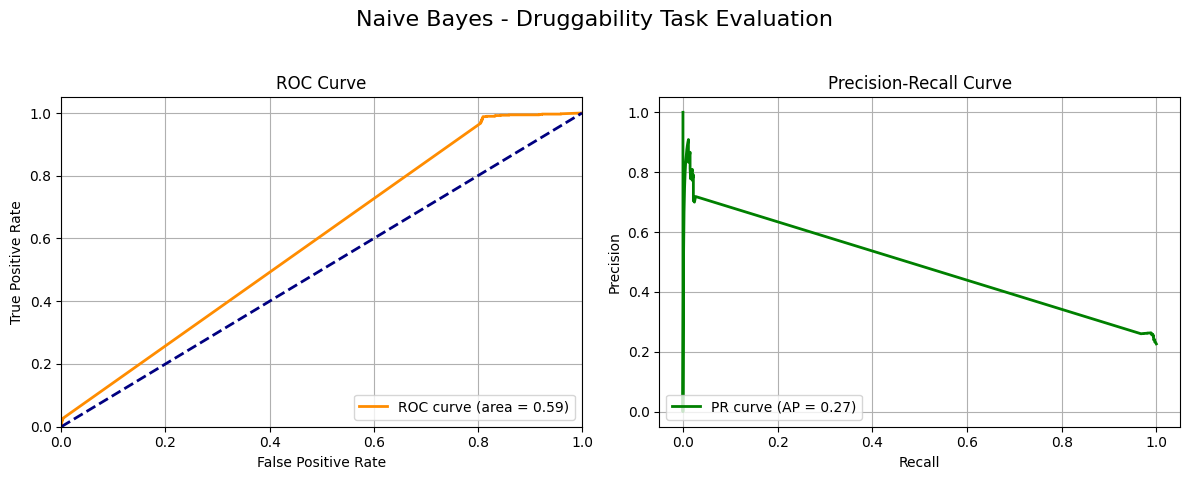


--- Evaluating Model: KNN ---


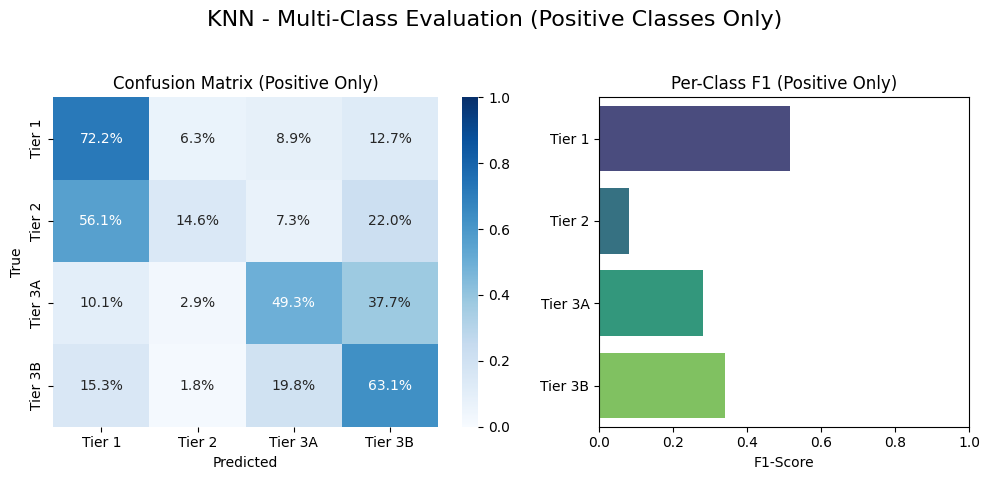

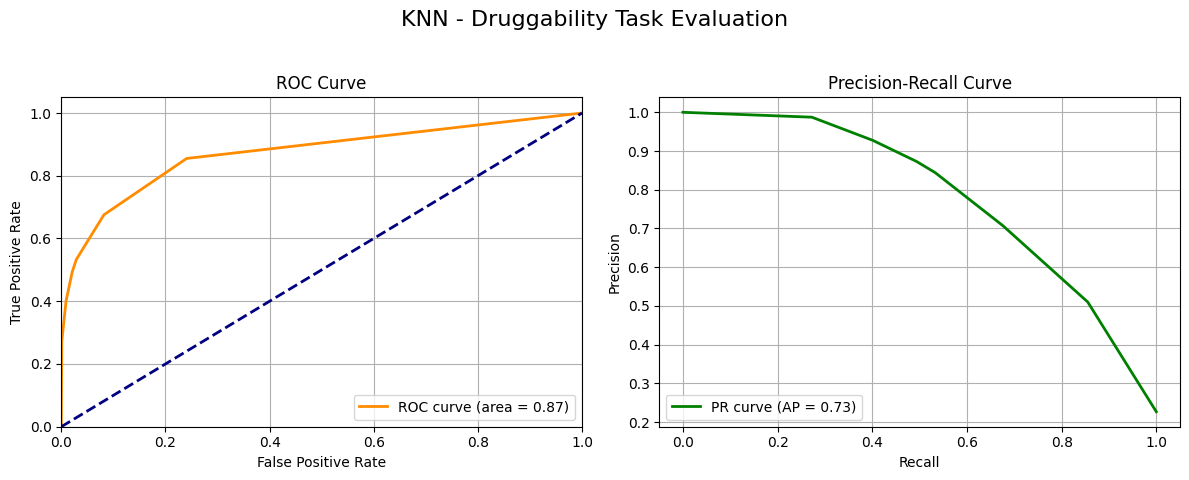


--- Evaluating Model: Decision Tree ---


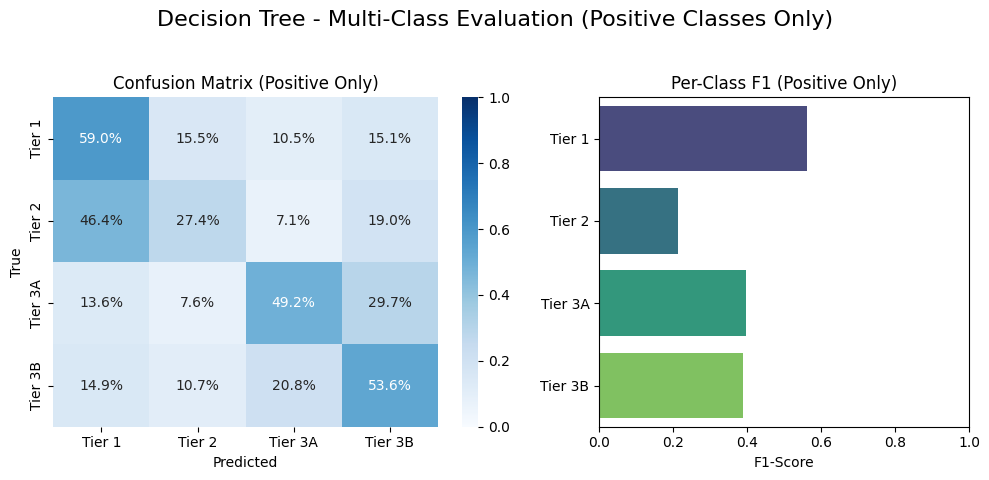

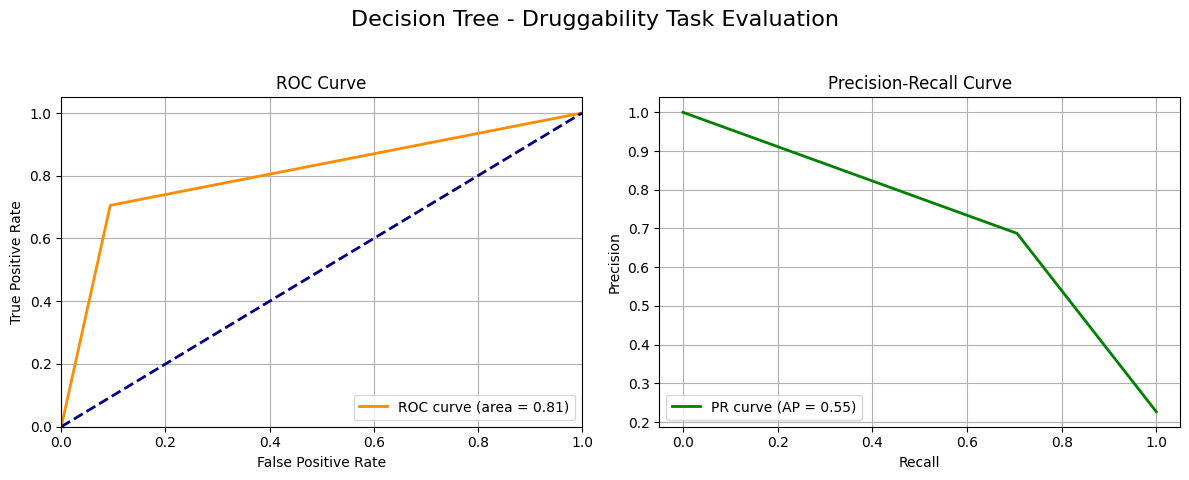


--- Evaluating Model: MLP ---


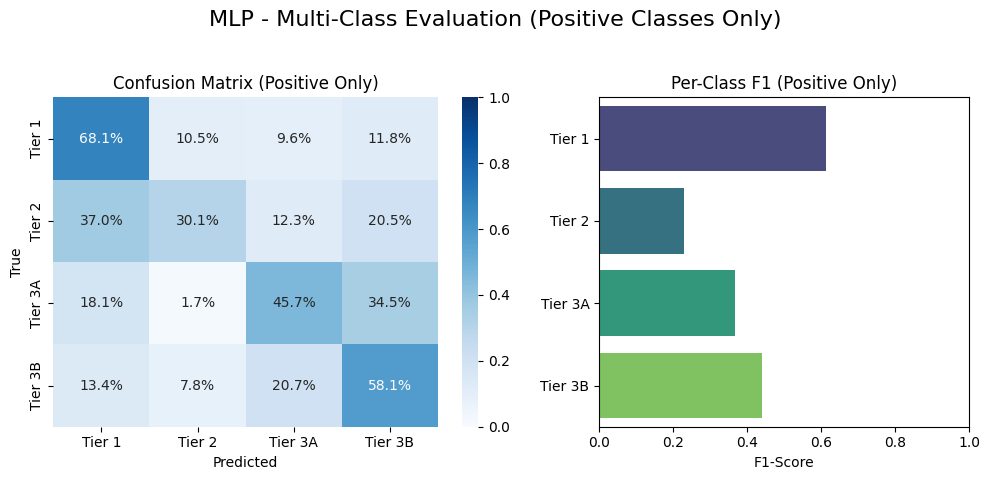

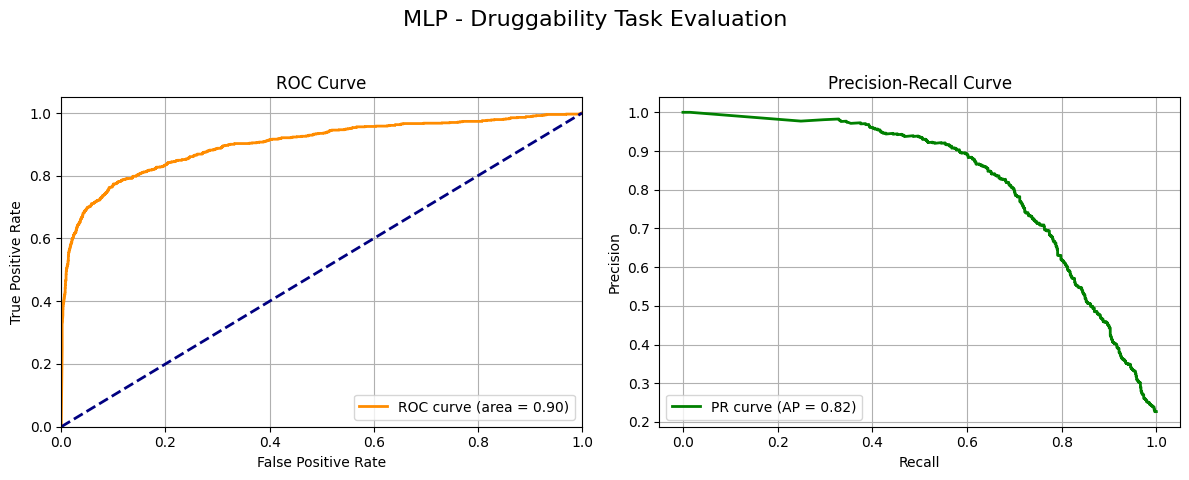


--- Evaluating Model: XGBoost ---


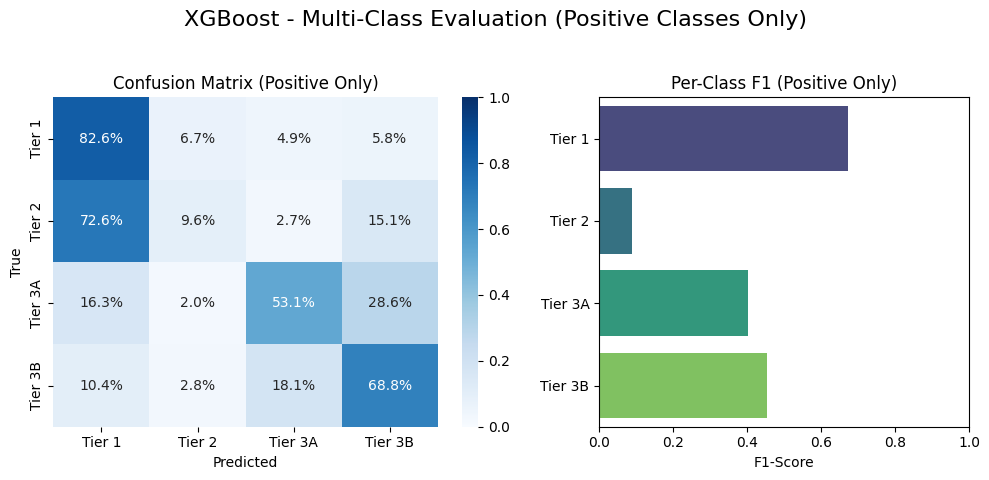

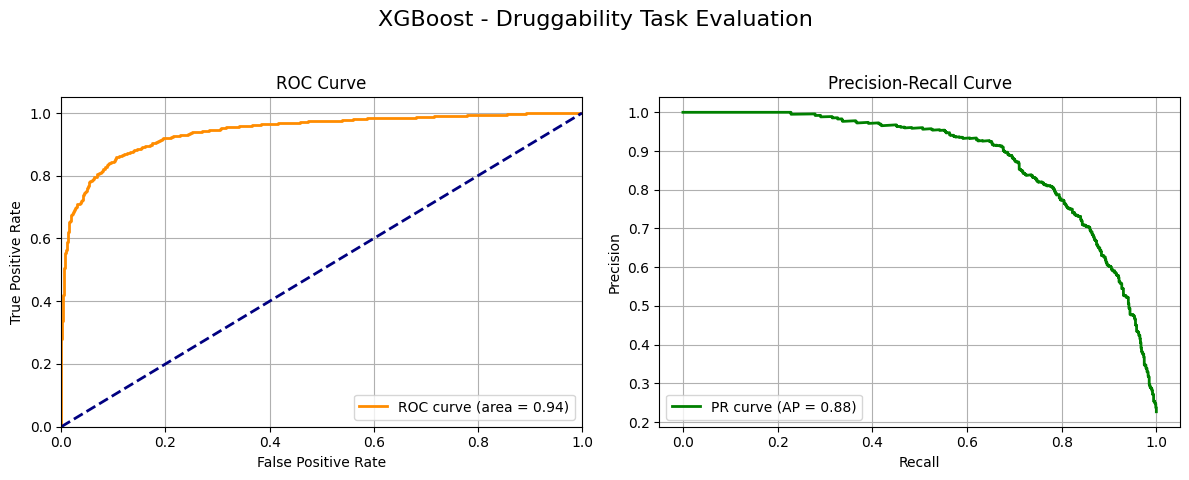


--- Summary Metrics Bar Plots ---


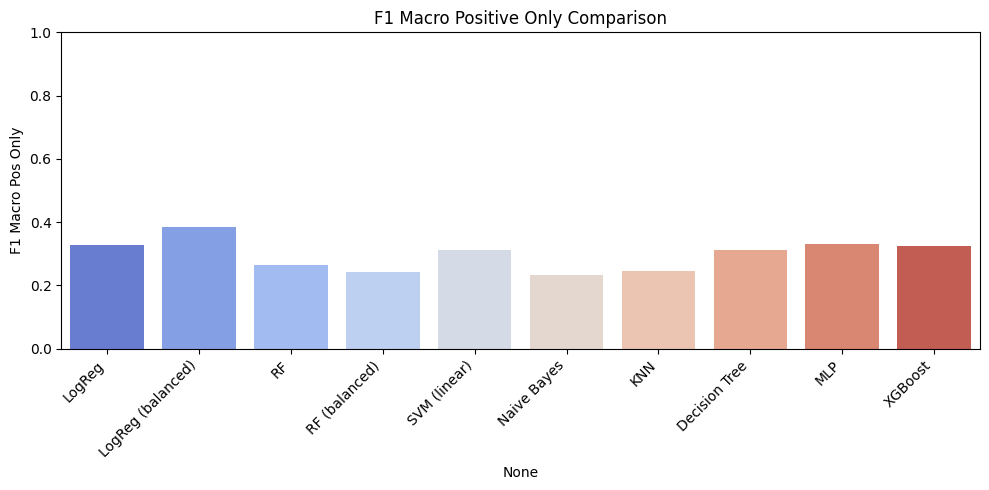

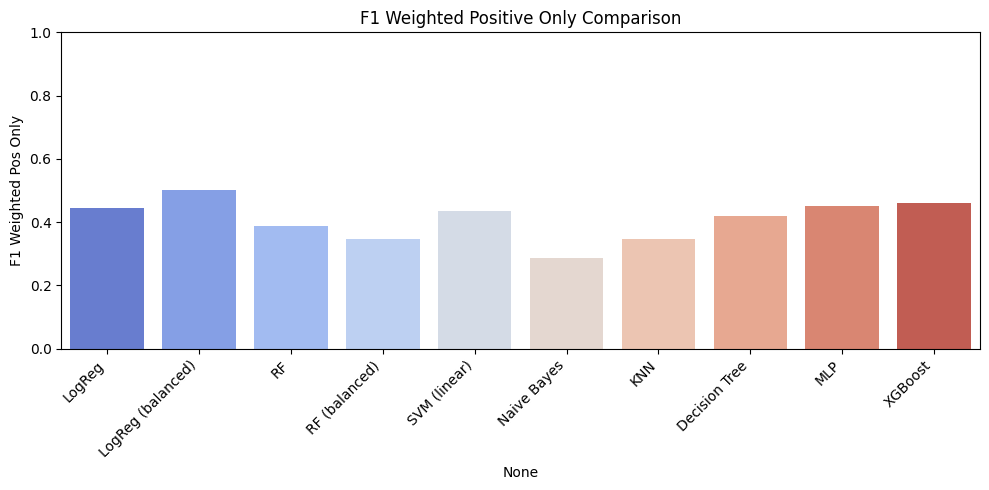

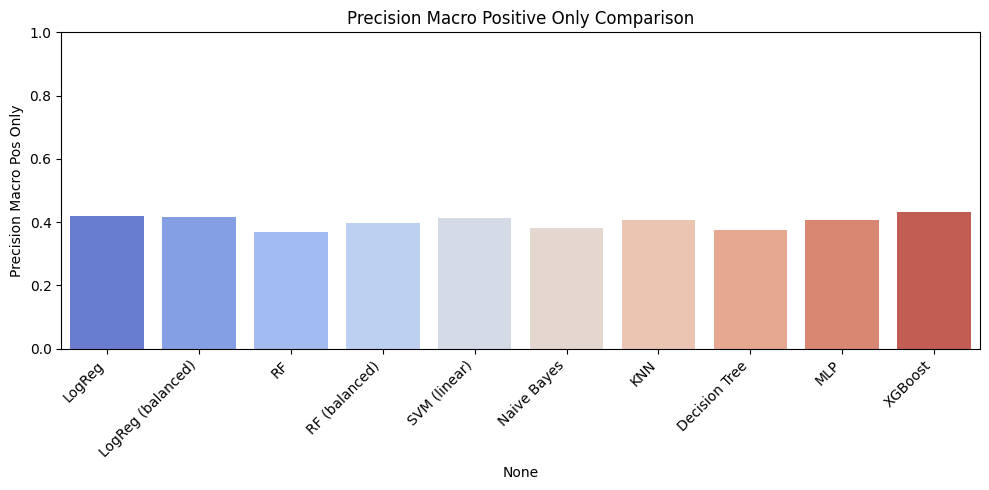

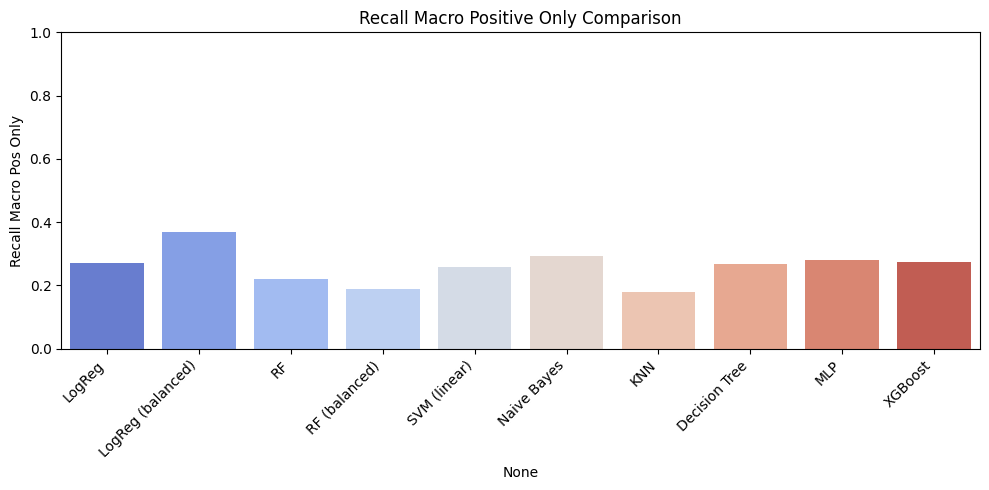

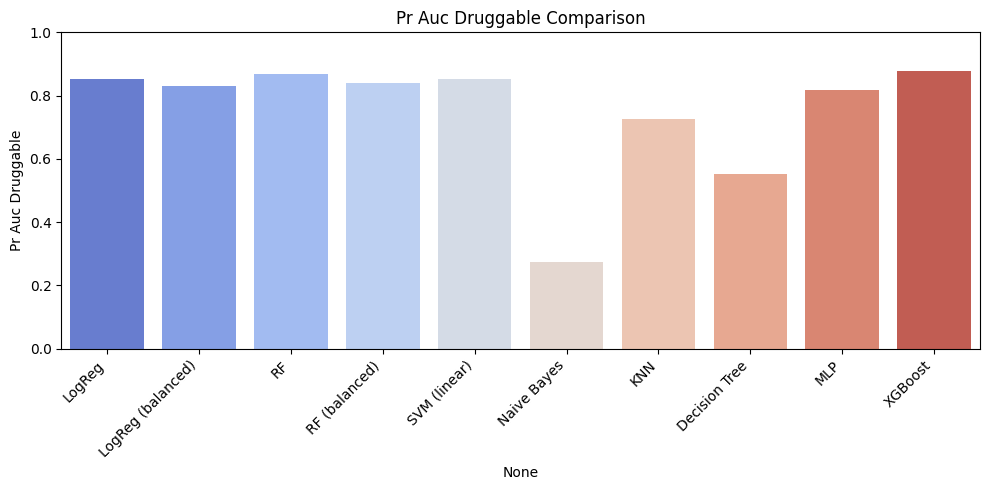

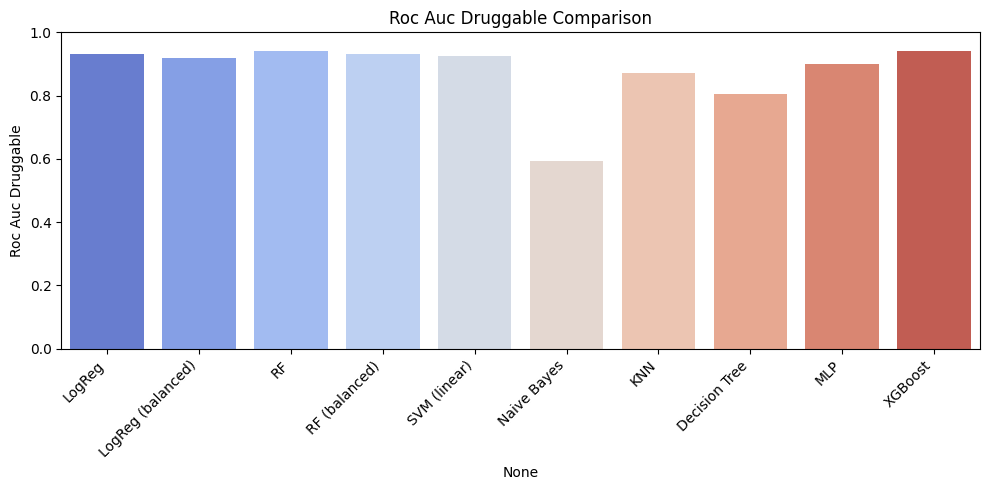


--- Final Summary Table ---
                  f1_macro_pos_only f1_weighted_pos_only  \
LogReg                     0.326348             0.445566   
LogReg (balanced)          0.384829             0.503133   
RF                         0.264742             0.387209   
RF (balanced)              0.243301             0.347694   
SVM (linear)                0.31209             0.434813   
Naive Bayes                0.232623             0.285691   
KNN                        0.244126             0.347487   
Decision Tree              0.312345             0.420557   
MLP                        0.330347             0.451031   
XGBoost                    0.323647             0.460153   

                  precision_macro_pos_only recall_macro_pos_only  \
LogReg                             0.41844              0.270421   
LogReg (balanced)                 0.415027              0.370112   
RF                                0.367768              0.221792   
RF (balanced)                     0.39

In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc # <--- Add auc here
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from matplotlib.gridspec import GridSpec # For more flexible subplot layouts
import warnings

warnings.filterwarnings("ignore")

# ----------------------------- SETUP -----------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------------- Load data from graph ---------------------
GRAPH_PATH = "/home/zihend1/Genesis/KNOT/data/gene_graph.pt"
data = torch.load(GRAPH_PATH)
if torch.isnan(data.x).any():
    data.x[torch.isnan(data.x)] = 0
X_all = data.x.cpu().numpy()

# ------------------------ Label processing ------------------------
y_raw = np.array(data.y)
label_map = {'-1': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 3A': 3, 'Tier 3B': 4}
y = np.vectorize(label_map.get)(y_raw)
class_names = ["Unknown", "Tier 1", "Tier 2", "Tier 3A", "Tier 3B"]
# y_bin is not directly used in the current evaluation logic, but kept for reference
# y_bin = label_binarize(y, classes=np.arange(len(class_names))) 

# ----------------------- Train-test split -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=SEED
)
# y_test_bin is only needed for plotting ROC/PR curves directly with label_binarize,
# but we will use y_test_druggable for the binary task
# y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names))) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------ Model dictionary ------------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=SEED),
    "LogReg (balanced)": LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced', random_state=SEED),
    "RF": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "RF (balanced)": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED),
    "SVM (linear)": SVC(kernel='linear', probability=True, random_state=SEED), # Added SVM back for comparison
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=SEED),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=SEED)
}

# -------------------- Modified Evaluation with Enhanced Plotting ---------------------
def is_druggable_class(y):  # Tier 1–3B = 1, Non-druggable = 0
    return np.where(y > 0, 1, 0)

results = {}

for name, clf in models.items():
    print(f"\n--- Evaluating Model: {name} ---")

    use_scaled = any(k in name for k in ["LogReg", "SVM", "Naive", "KNN", "MLP"])
    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te) if hasattr(clf, "predict_proba") else None

    # Task 1: Binary Druggable vs Non-Druggable
    y_test_druggable = is_druggable_class(y_test)
    if y_prob is not None:
        # Sum probabilities for all positive tiers (1,2,3,4) for druggable score
        # Check if y_prob has enough columns (i.e., if it's a multi-class classifier's output)
        if y_prob.shape[1] > 1:
            druggable_score = y_prob[:, 1:].sum(axis=1) # sum Tier1–3B probability
        else: # For binary classifiers that might output only one prob column (e.g., SVC(prob=True) for binary)
            druggable_score = y_prob[:, 0] if clf.classes_[1] == 1 else (1 - y_prob[:, 0])
            
        pr_auc = average_precision_score(y_test_druggable, druggable_score)
        fpr, tpr, _ = roc_curve(y_test_druggable, druggable_score)
        roc_auc = auc(fpr, tpr)
    else:
        pr_auc = np.nan
        roc_auc = np.nan
        fpr, tpr = None, None # Ensure these are None if not calculated

    # Task 2: Multi-class evaluation for known positives (Tier 1–3B)
    known_pos_idx = y_test != 0 # Indices of samples that are Tier 1-3B
    
    # Filter true and predicted labels for known positive samples
    y_true_pos = y_test[known_pos_idx]
    y_pred_pos = y_pred[known_pos_idx]

    # Ensure there are positive samples in the test set to avoid errors
    if np.sum(known_pos_idx) > 0 and len(np.unique(y_true_pos)) > 1: # Also check if more than one class exists in true positives
        f1_macro_pos = f1_score(y_true_pos, y_pred_pos, average="macro")
        f1_weighted_pos = f1_score(y_true_pos, y_pred_pos, average="weighted")
        prec_macro_pos = precision_score(y_true_pos, y_pred_pos, average="macro")
        rec_macro_pos = recall_score(y_true_pos, y_pred_pos, average="macro")
        
        # Only compute CM and report if classes are properly represented
        # Get unique classes present in y_true_pos and y_pred_pos that are also in class_names[1:]
        relevant_labels = np.unique(np.concatenate((y_true_pos, y_pred_pos)))
        relevant_labels = [lbl for lbl in relevant_labels if lbl in [1, 2, 3, 4]]

        if len(relevant_labels) > 0:
            cm = confusion_matrix(y_true_pos, y_pred_pos, labels=relevant_labels)
            cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
            report = classification_report(
                y_true_pos, y_pred_pos, labels=relevant_labels,
                output_dict=True, target_names=[class_names[l] for l in relevant_labels], zero_division=0
            )
            # Extract per-class F1 for plotting
            per_class_f1s = {k: report[k]["f1-score"] for k in report if k in class_names[1:]}
        else:
            cm_norm = None
            report = None
            per_class_f1s = {}
    else:
        f1_macro_pos = f1_weighted_pos = prec_macro_pos = rec_macro_pos = np.nan
        cm_norm = report = None
        per_class_f1s = {}

    results[name] = {
        "f1_macro_pos_only": f1_macro_pos,
        "f1_weighted_pos_only": f1_weighted_pos,
        "precision_macro_pos_only": prec_macro_pos,
        "recall_macro_pos_only": rec_macro_pos,
        "pr_auc_druggable": pr_auc,
        "roc_auc_druggable": roc_auc,
        "cm": cm_norm,
        "report": report, # Store full report for detailed inspection if needed
        "per_class_f1s": per_class_f1s, # Store per-class F1 for plotting
        "fpr": fpr,
        "tpr": tpr,
        "druggable_precision": None, # Will store for PR curve plot
        "druggable_recall": None # Will store for PR curve plot
    }

    # Enhanced Plotting: One figure for multi-class, one for binary
    
    # Figure 1: Multi-class Evaluation (Positive Classes Only)
    if cm_norm is not None:
        fig = plt.figure(figsize=(10, 5))
        gs = GridSpec(1, 2, figure=fig, width_ratios=[1.3, 1]) # GridSpec for flexible layout

        # Subplot 1: Confusion Matrix
        ax0 = fig.add_subplot(gs[0, 0])
        sns.heatmap(cm_norm, annot=True, fmt=".1%", cmap="Blues", vmin=0, vmax=1,
                    xticklabels=[class_names[l] for l in relevant_labels], 
                    yticklabels=[class_names[l] for l in relevant_labels], ax=ax0)
        ax0.set_title("Confusion Matrix (Positive Only)")
        ax0.set_xlabel("Predicted")
        ax0.set_ylabel("True")

        # Subplot 2: Per-Class F1 Scores
        ax1 = fig.add_subplot(gs[0, 1])
        if per_class_f1s:
            f1s_data = pd.DataFrame(list(per_class_f1s.items()), columns=['Class', 'F1-Score'])
            sns.barplot(x='F1-Score', y='Class', data=f1s_data, palette="viridis", ax=ax1) # Switched to horizontal bar for better labels
            ax1.set_xlim(0, 1)
            ax1.set_title("Per-Class F1 (Positive Only)")
            ax1.set_xlabel("F1-Score")
            ax1.set_ylabel("") # Remove y-label if class names are on y-axis
        else:
            ax1.text(0.5, 0.5, "No per-class F1 data", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
            ax1.set_title("Per-Class F1 (Positive Only)")

        fig.suptitle(f"{name} - Multi-Class Evaluation (Positive Classes Only)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to prevent title overlap
        plt.show()

    # Figure 2: Binary Druggability Task Evaluation (ROC & PR Curve)
    if y_prob is not None:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"{name} - Druggability Task Evaluation", fontsize=16)

        # Subplot 1: ROC Curve
        ax0.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax0.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax0.set_xlim([0.0, 1.0])
        ax0.set_ylim([0.0, 1.05])
        ax0.set_xlabel('False Positive Rate')
        ax0.set_ylabel('True Positive Rate')
        ax0.set_title('ROC Curve')
        ax0.legend(loc="lower right")
        ax0.grid(True)

        # Subplot 2: PR Curve
        precision_vals, recall_vals, _ = precision_recall_curve(y_test_druggable, druggable_score)
        ax1.plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title('Precision-Recall Curve')
        ax1.legend(loc="lower left")
        ax1.grid(True)
        
        # Store for summary table if needed (optional)
        results[name]["druggable_precision"] = precision_vals 
        results[name]["druggable_recall"] = recall_vals

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect
        plt.show()

# ---------------------- Summary Plot ----------------------
df_results = pd.DataFrame(results).T
df_results = df_results[[
    "f1_macro_pos_only", "f1_weighted_pos_only", 
    "precision_macro_pos_only", "recall_macro_pos_only", 
    "pr_auc_druggable", "roc_auc_druggable"
]]

# For summary bar plots, we'll iterate through metrics and plot them
print("\n--- Summary Metrics Bar Plots ---")
for metric in df_results.columns:
    if metric in ["cm", "report", "per_class_f1s", "fpr", "tpr", "druggable_precision", "druggable_recall"]:
        continue # Skip non-scalar metrics
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=df_results.index, y=df_results[metric], palette="coolwarm")
    plt.title(f"{metric.replace('_', ' ').replace('pos only', 'positive only').title()} Comparison")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.ylim(0, 1) # Set y-limit for metrics like F1, Precision, Recall, AUC
    plt.tight_layout()
    plt.show()

print("\n--- Final Summary Table ---")
print(df_results.round(3))